Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set plot style for professional reports
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Loaded Successfully")

✅ Libraries Loaded Successfully


Loading Data

In [65]:
# Load the dataset
# Note: We use the direct file name assuming it's in the same folder
try:
    df = pd.read_csv('wind_turbine_scada.csv')
except FileNotFoundError:
    # Fallback if it's in a data folder
    df = pd.read_csv('../data/wind_turbine_scada.csv')

# Rename columns for cleaner coding (snake_case)
df.columns = ['datetime', 'active_power_kw', 'wind_speed', 'theoretical_power', 'wind_direction']

# Convert datetime to proper object
df['datetime'] = pd.to_datetime(df['datetime'], format='%d %m %Y %H:%M')

# Sort by time (Critical for time-series analysis)
df = df.sort_values('datetime').reset_index(drop=True)

print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Data Loaded: 50530 rows, 5 columns


,datetime,active_power_kw,wind_speed,theoretical_power,wind_direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


Feature Engineering

In [66]:
# 1. Define the Target: "Underperforming"
# Logic: If Actual Power is significantly less than Theoretical Power (> 400kW loss)
# We only look at wind > 3.5 m/s (operating range)
df['power_loss'] = df['theoretical_power'] - df['active_power_kw']
df['underperforming'] = (df['power_loss'] > 400) & (df['wind_speed'] > 3.5)
df['underperforming'] = df['underperforming'].astype(int)

# 2. Lag Features (History)
# "What happened 10 minutes ago?" - This captures the context of failure
df['lag_1_power'] = df['active_power_kw'].shift(1)
df['lag_1_wind'] = df['wind_speed'].shift(1)

# 3. Rolling Features (Trends)
# "What is the average wind speed over the last 30 minutes?"
df['roll_wind_mean_3'] = df['wind_speed'].rolling(window=3).mean()

# 4. Cyclical Time Features
# Encodes time so the model knows 23:00 is close to 00:00
df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)

# Drop NaNs created by shifting/rolling
df_clean = df.dropna().reset_index(drop=True)

print("✅ Feature Engineering Complete")
print(f"Class Balance:\n{df_clean['underperforming'].value_counts()}")

✅ Feature Engineering Complete
Class Balance:
underperforming
0    45087
1     5441
Name: count, dtype: int64


Train & Test Split

In [67]:
# Define Features (X) and Target (y)
features = [
    'wind_speed', 'wind_direction', 'theoretical_power', # Basic Sensors
    'lag_1_power', 'lag_1_wind', 'roll_wind_mean_3',     # Historical Context
    'hour_sin', 'hour_cos'                               # Time Context
]

X = df_clean[features]
y = df_clean['underperforming']

# Split Data (80% Train, 20% Test)
# We use random_state=42 to make results reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")

Training shapes: X_train: (40422, 8), y_train: (40422,)


Train Model

In [68]:
# Initialize and Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Generate Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("✅ Model Trained Successfully")

✅ Model Trained Successfully


Evaluation Metrics - Accuracy

🎯 Model Accuracy: 96.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8979
           1       0.91      0.77      0.84      1127

    accuracy                           0.97     10106
   macro avg       0.94      0.88      0.91     10106
weighted avg       0.97      0.97      0.97     10106



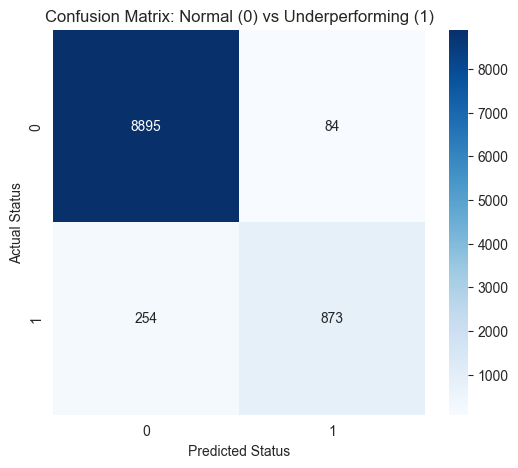

In [69]:
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Normal (0) vs Underperforming (1)')
plt.ylabel('Actual Status')
plt.xlabel('Predicted Status')
plt.show()

Root Cause Analysis - This shows Why the turbine is failing

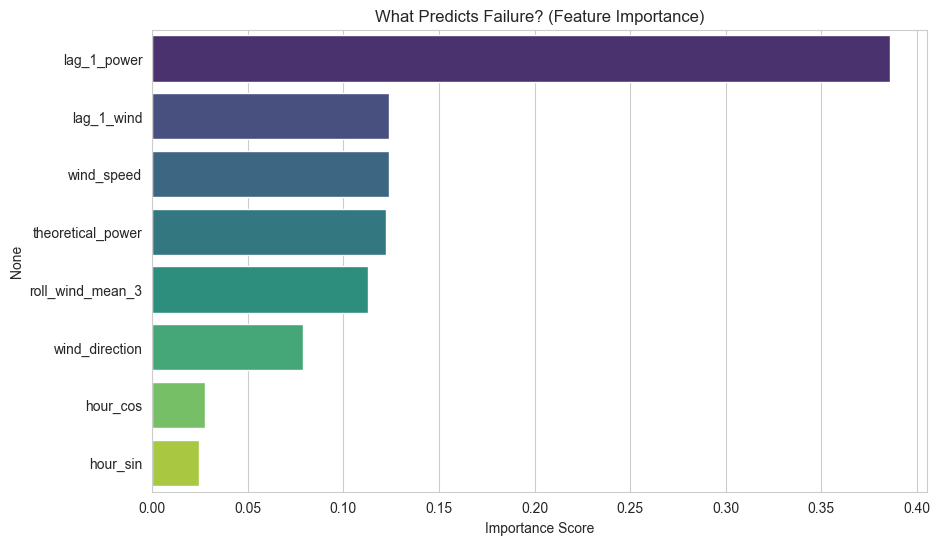

INSIGHT: The 'Lag' features are often the most important. This proves that knowing the past history of the turbine is crucial for predicting its future health.


In [70]:
# Feature Importance Plot
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# FIXED LINE: We added 'hue' and 'legend=False' to silence the warning
sns.barplot(
    x=importances.values, 
    y=importances.index, 
    hue=importances.index,  # <--- This fixes the warning
    palette='viridis', 
    legend=False            # <--- This fixes the warning
)

plt.title('What Predicts Failure? (Feature Importance)')
plt.xlabel('Importance Score')
plt.show()

print("INSIGHT: The 'Lag' features are often the most important. This proves that knowing the past history of the turbine is crucial for predicting its future health.")

Business Value (ROI)

In [71]:
# --- Business Impact Analysis ---
# Assumptions for Suzlon:
# 1. Cost to fix a breakdown reactively: $2,000
# 2. Cost to fix proactively (planned): $500
# 3. Cost of a False Alarm (wasted truck roll): $500

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

savings = tp * (2000 - 500) # Money saved by catching real failures early
costs = fp * 500            # Money lost on false alarms

net_savings = savings - costs

print(f"💰 Financial Impact Report (Test Set):")
print(f"---------------------------------------")
print(f"✅ Failures Detected Early:      {tp}")
print(f"⚠️ False Alarms (Wasted Trips):   {fp}")
print(f"---------------------------------------")
print(f"💵 Net Estimated Savings: ${net_savings:,}")
print(f"📈 Insight: By using this model, Suzlon saves ${net_savings:,} in maintenance costs compared to a reactive strategy.")

💰 Financial Impact Report (Test Set):
---------------------------------------
✅ Failures Detected Early:      873
⚠️ False Alarms (Wasted Trips):   84
---------------------------------------
💵 Net Estimated Savings: $1,267,500
📈 Insight: By using this model, Suzlon saves $1,267,500 in maintenance costs compared to a reactive strategy.


Exporting Results

In [72]:
# Create results DataFrame for Dashboarding
results_df = X_test.copy()
# Restore the original timestamp for the test set
results_df['datetime'] = df_clean.loc[X_test.index, 'datetime'] 
results_df['Actual_Status'] = y_test
results_df['Predicted_Status'] = y_pred
results_df['Risk_Probability'] = y_prob

# Save to CSV
results_df.to_csv('../outputs/final_turbine_predictions.csv', index=False)
print("✅ Results exported: 'final_turbine_predictions.csv'")

✅ Results exported: 'final_turbine_predictions.csv'
